# Setup

In [1]:
!pip install flax

In [2]:
from functools import partial
import numpy as np
import jax, jax.numpy as jp, jax.tree_util as tu, jax.random as rax
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

backstop = jax.lax.stop_gradient
deepmap = tu.tree_map

def value_and_naive_gradients(f, separable=False, has_aux=False):
  # NOTE agents is a list of pytrees, one for each agent; they are not stacked
  def fn(agents):
    ugh = jax.vjp(f, agents, has_aux=has_aux)
    if has_aux: # :-///////////////////////////////////////
      y, df, aux = ugh
      val = (y,aux)
    else:
      y, df = ugh
      val = y
    if separable:
      # compute it in a single backprop. this is possible if the jacobian of f is diagonal.
      # concretely this is true for us if
      #   - f is diced game return, and has rewards multiplied only with agent's own logps.
      #   - f is vhat, and it has stop() on the opponent embedding.
      # it remains true if f is a linear combination of these two.
      [dxs] = df(np.ones(len(agents), dtype="float32"))
    else:
      dxs = [df((np.arange(len(agents)) == i).astype("float32"))[0][i]
             for i, _ in enumerate(agents)]
    assert all(type(dx) == type(agent) for dx,agent in zip(dxs, agents))
    return val, dxs
  return fn
def naive_gradients(f, separable=False, has_aux=False):
  def fn(agents):
    y, dxs = value_and_naive_gradients(f, separable=separable, has_aux=has_aux)(agents)
    return dxs
  return fn

def unzip2(xs):
  xs = list(xs)
  if not xs: return [],[]
  return list(map(list, zip(*xs)))

def subplots(things, subplot_wh_hint=(8, 8), **kwargs):
  m, n = len(things), max(map(len, things))
  sw, sh = subplot_wh_hint
  size = jp.array([sw * n, sh * m])
  # guard against accidentally huge figures
  while np.prod(size) > 32 ** 2:
    size = size // 2
  fig, axes = plt.subplots(m, n, figsize=tuple(size), squeeze=False, **kwargs)
  for i, row in enumerate(things):
    for j, spec in enumerate(row):
      if callable(spec):
        plotter, *args = spec,
      else:
        plotter, *args = spec
      plotter(axes[i, j], *args)
  return fig

def logspacedindices(xs): # [*0:10:1, *10:100:10, *100:1000:100, ... -1]
  xs = list(xs)
  ys = [0]
  n = len(str(len(xs))) # intlog10
  for i in range(n):
    ys.extend(np.arange(1, 10) * 10 ** i)
  for y in ys:
    if y < len(xs) - 1: # exclude last element of xs here
      yield y
  yield len(xs) - 1 # always include last element of xs, exactly once

assert list(logspacedindices(range(303))) == [*range(10), *range(10, 100, 10), 100, 200, 300, 302]

In [3]:
@struct.dataclass
class Adam:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    moment1 = deepmap(lambda m, dx: m + (1 - self.beta1) * (dx - m), self.moment1, grad)
    moment2 = deepmap(lambda m, dx: m + (1 - self.beta2) * (dx ** 2 - m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m / (1 - self.beta1 ** n), moment1)
    dbmoment2 = deepmap(lambda m: m / (1 - self.beta2 ** n), moment2)
    step = deepmap(lambda dm1, dm2, x: self.lr * (dm1 / (self.eps + dm2**0.5)),
                   dbmoment1, dbmoment2, params)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

@struct.dataclass
class Rmsprop:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    moment2 = deepmap(lambda m, dx: m + (1 - self.beta2) * (dx ** 2 - m), self.moment2, grad)
    n = self.n + 1
    dbmoment2 = deepmap(lambda m: m / (1 - self.beta2 ** n), moment2)
    step = deepmap(lambda x, dx, dm2: self.lr * (dx / (self.eps + dm2**0.5)),
                   params, grad, dbmoment2)
    new_self = self.replace(moment2=moment2, n=n)
    return new_self, step

@struct.dataclass
class Sga:
  lr: float = struct.field(pytree_node=False, default=1e-3)

  @classmethod
  def make_for(cls, params, **hp):
    return cls(**hp)

  def __call__(self, params, grad):
    return self, grad

class ResidualBlock(nn.Module):
  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(nn.Dense(size, name="X")(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = self.param("G", nn.initializers.zeros, [z.shape[-1]])
    gate = nn.sigmoid(gate)
    return gate*x + (1-gate)*y

# Game definition

In [4]:
# the logistic game
def f(z): # z is a pair of scalars
  x, y = z
  sx, sy = jax.nn.sigmoid(z)
  return -(4 * jp.array([sx * (1 - 2 * sy),
                         sy * (1 - 2 * sx)])
           + 1 * ((x * y) ** 2 + (x ** 2 - y ** 2) ** 2) / 10000)

def f_tandem(z):
  return -(z**2).sum() +2*z

def diagjac(f,z):
  return jp.diag(jax.jacrev(f)(z))

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta ** 2 / 2,
                  threshold * delta - threshold ** 2 / 2)

def qr_loss(xs, ys):
  [n] = xs.shape
  mid = (jp.arange(n) + 0.5) / n  # quantile midpoints
  dq = ys[None, :] - xs[:, None]
  loss = jp.abs(mid[:, None] - (dq<0)) * huber(dq)
  return loss.sum() / n


In [5]:
xs = ys = np.linspace(-10, 10, 29)
zs = np.stack(np.meshgrid(xs, ys, indexing="ij"), axis=-1)
print(zs.shape) # [29, 29, 2]

def plot_surface(ax, data, title=None, **kwargs):
  ax.plot_surface(zs[..., 0], zs[..., 1], data, cmap="magma", **kwargs)
  if title:
    ax.set_title(title)

def plot_contour(ax, data, title=None, **kwargs):
  ax.contourf(zs[..., 0], zs[..., 1], data, cmap="magma", **kwargs)
  if title:
    ax.set_title(title)

def plot_quiver(ax, data, title=None, **kwargs):
  ax.quiver(zs[..., 0], zs[..., 1], data[..., 0], data[..., 1], **kwargs)
  if title:
    ax.set_title(title)

def plot_quiver2(ax, data, title=None, **kwargs):
  ax.quiver(zs[..., 0], zs[..., 1], data[..., 0], data[..., 1], angles="xy", scale_units="xy", scale=1., **kwargs)
  if title:
    ax.set_title(title)

def plot_quiver2_zoom(ax, data, title=None, **kwargs):
  ax.quiver(zs[..., 0], zs[..., 1], data[..., 0], data[..., 1], angles="xy", scale_units="xy", scale=1., **kwargs)
  ax.set_xlim((-5, 5))
  ax.set_ylim((-5, 5))
  if title:
    ax.set_title(title)


(29, 29, 2)


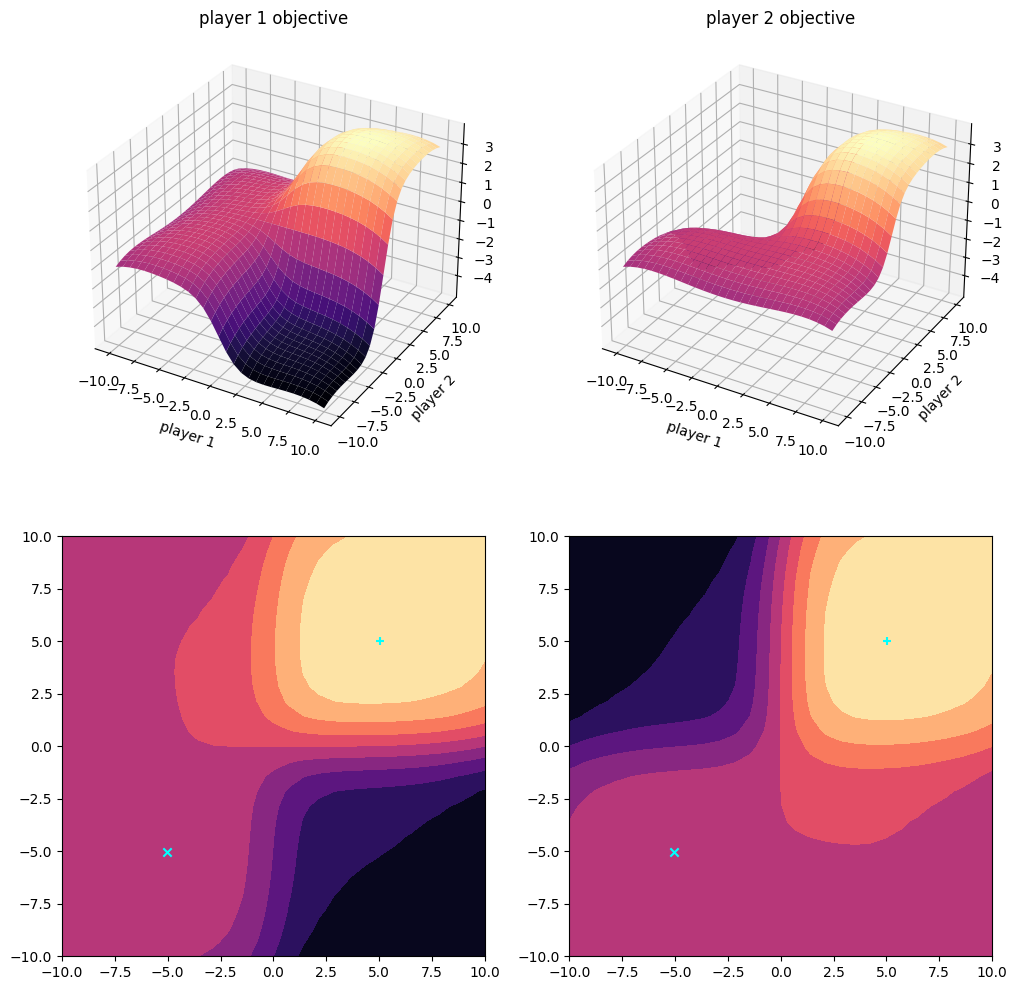

In [6]:
def train_simple(f, lr=1., batch_size=16, num_steps=200, seed=1):
  return {"objective": f, **train_simpleg(partial(diagjac, f), lr=lr, batch_size=batch_size, num_steps=num_steps, seed=seed)}
def train_simpleg(g, lr=1., batch_size=16, num_steps=200, seed=1):
  @jax.jit
  def step_fn(optimizer, x):
    dx = g(x)
    optimizer, dx = optimizer(x, dx)
    x = deepmap(lambda x, dx: x+dx, x, dx)
    return optimizer, x

  x = (rax.uniform(rax.PRNGKey(seed), shape=[batch_size, 2]) * 2 - 1) * 8
  optimizer = jax.vmap(partial(Sga.make_for, lr=lr))(x)
  trace = [x]
  for _ in range(num_steps):
    optimizer, x = jax.vmap(step_fn)(optimizer, x)
    trace.append(x)
  trace = np.stack(trace, axis=1) # [batch, time, players]
  return dict(trace=trace)

def train_fromg(g, x, lr=1., num_steps=200):
  @jax.jit
  def step_fn(optimizer, x):
    dx = g(x)
    optimizer, dx = optimizer(x, dx)
    x = deepmap(lambda x, dx: x+dx, x, dx)
    return optimizer, x

  optimizer = jax.vmap(partial(Sga.make_for, lr=lr))(x)
  trace = [x]
  for _ in range(num_steps):
    optimizer, x = jax.vmap(step_fn)(optimizer, x)
    trace.append(x)
  trace = np.stack(trace, axis=1) # [batch, time, players]
  return dict(trace=trace)

goodx,badx = train_fromg(partial(diagjac,f), jp.array([[5.,5.],[-5.,-5.]]))["trace"][:,-1]
fs = jax.vmap(jax.vmap(f))(zs)

example_init = zs[::6,::6].reshape([-1,2])
example_init = example_init + rax.normal(rax.PRNGKey(3), shape=example_init.shape)
naive_trails = train_fromg(partial(diagjac,f), example_init)["trace"]
naive_fs = jax.vmap(jax.vmap(f))(naive_trails)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221, projection="3d")
plot_surface(ax, fs[..., 0])
ax.set_xlabel("player 1")
ax.set_ylabel("player 2")
ax.set_title("player 1 objective")
ax = fig.add_subplot(222, projection="3d")
plot_surface(ax, fs[..., 1])
ax.set_xlabel("player 1")
ax.set_ylabel("player 2")
ax.set_title("player 2 objective")
ax = fig.add_subplot(223)
plot_contour(ax, fs[..., 0], levels=10)
ax.scatter(*goodx[:,None], c="aqua", marker="+")
ax.scatter(*badx[:,None], c="aqua", marker="x")
ax = fig.add_subplot(224)
plot_contour(ax, fs[..., 1], levels=10)
ax.scatter(*goodx[:,None], c="aqua", marker="+")
ax.scatter(*badx[:,None], c="aqua", marker="x")

def simple_plot_contour(f, ax, player):
  fs = jax.vmap(jax.vmap(f))(zs)
  ax.contourf(zs[..., 0], zs[..., 1], fs[..., player], cmap="magma", levels=10)
  ax.set_title(f"P {player}")
  ax.set_axis_off()
def simple_plot_trajectory(trace, ax):
  ax.plot(trace[..., 0].T, trace[..., 1].T, linewidth=2)
  #ax.set_title(name)
  ax.set_xlim((-10, +10))
  ax.set_ylim((-10, +10))
  ax.set_axis_off()

def compute_basins(g, T=100):
  @jax.jit
  def step_fn(optimizer, x):
    dx = g(x)
    optimizer, dx = optimizer(x, dx)
    x = deepmap(lambda x,dx: x+dx, x,dx)
    return optimizer, x
  x = zs
  optimizer = jax.vmap(jax.vmap(partial(Sga.make_for, lr=1)))(x)
  for _ in range(T):
    optimizer, x = jax.vmap(jax.vmap(step_fn))(optimizer, x)
  return x
def plot_basinsg(g, ax, title="basins", **kwargs):
  basins = compute_basins(g)
  if False:
    v = basins.max(axis=-1)  # across players; show the worst case
    ax.imshow(v, cmap="RdBu", interpolation="none", origin="lower", vmin=-8, vmax=+8, **kwargs)
  else:
    v = (basins>0).all(axis=-1)  # show whether players ended up in upper right quadrant
    ax.imshow(v, cmap="gray", interpolation="none", origin="lower", vmin=0, vmax=1, **kwargs)
  ax.set_title(title)
  ax.set_axis_off()
def plot_basins(f, ax, title="basins", **kwargs):
  plot_basinsg(partial(diagjac, f), ax, title=title, **kwargs)


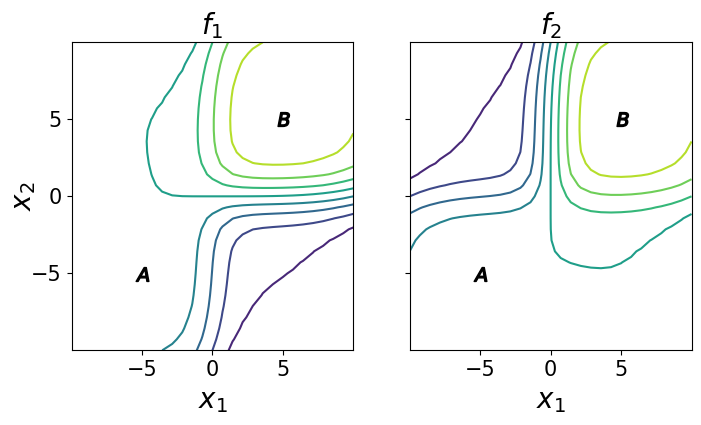

In [7]:
def plot_objective(ax, player):
  ax.contour(zs[..., 0], zs[..., 1], fs[...,player], cmap="viridis", levels=10)
  #ax.plot(naive_trails[...,0].T, naive_trails[...,1].T, linewidth=1, c="k")
  ax.scatter(*goodx[:,None], c="k", marker="$B$", s=100)
  ax.scatter(*badx[:,None], c="k", marker="$A$", s=100)
  extent = 10 #- 0.1
  ax.set_xlim((-extent,+extent)); ax.set_ylim((-extent,+extent))
  ax.set_xlabel("$x_1$", fontsize=20, labelpad=5)
  if player == 0:
    ax.set_ylabel("$x_2$", fontsize=20, labelpad=-5)
  ax.set_title(f"$f_{player+1}$", fontsize=20)
  ticks = [-5, 0, 5]
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  ax.tick_params(labelsize=15)

subplots([[partial(plot_objective, player=i) for i in range(2)]],
         subplot_wh_hint=(4, 4), sharex=True, sharey=True)
pass

# Meta-values

In [8]:
class VHatModule(nn.Module):
  size: int = 64
  quantiles: int = 1
  @nn.compact
  def __call__(self, x, gamma):
    assert x.shape == (2,) # two players, a scalar policy each
    assert gamma.shape == (2,)
    x = x/10#nn.tanh(x/10)
    h = jp.stack([x,gamma], axis=-1) # [players, features]
    h = nn.gelu(nn.Dense(self.size, name="L0")(h))
    h = ResidualBlock(name="R0")(h)
    h = nn.gelu(nn.Dense(self.size, name="L1")(h))
    h = jp.concatenate([h, h[::-1]], axis=-1) # add in opponent features
    h = nn.gelu(nn.Dense(self.size, name="L2")(h))
    h = ResidualBlock(name="R1")(h)
    h = nn.tanh(nn.Dense(self.size, name="L3")(h))
    y = nn.Dense(self.quantiles, name="output")(h)
    return y

@struct.dataclass
class VHat:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)
  def __call__(self, x, gamma):
    quantiles = self.quantiles(x, gamma)
    return quantiles.mean(axis=-1)
  def quantiles(self, x, gamma):
    return self.module.apply(dict(params=self.params), x, gamma)
  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, jp.zeros([2], dtype="float32"), jp.zeros([2], dtype="float32"))["params"]
    return cls(params=params, module=module)
  def bind_gamma(self, gamma):
    return partial(self, gamma=jp.full([2], gamma, dtype="float32"))

In [9]:
def vhat_loss_fn(vhat, xs, gamma):
  T, P = xs.shape
  assert gamma.shape == (P,)
  fs = jax.vmap(f)(xs)
  vs = jax.vmap(vhat.quantiles, in_axes=(0,None))(xs, gamma) # across time
  _,_,Q = vs.shape
  assert vs.shape == (T,P,Q)
  predictions = vs[:-1]
  if False: # TD(0)
    tvs = vs
    targets = (1-gamma[:,None])*fs[:-1,:,None] + gamma[:,None]*tvs[1:,:,:]
  else: # use lambda-returns computed by reverse scan  # NOTE requires stop on target
    tvs = backstop(vs)
    lamda = 0.9
    def body_fn(target, inputs):
      [f,tv] = inputs
      target = (1-gamma[...,None])*f[...,None] + gamma[...,None]*((1-lamda)*tv+lamda*target)
      return target,target
    _, targets = jax.lax.scan(body_fn, tvs[-1], [fs[:-1][::-1],tvs[1:][::-1]])
    targets = targets[::-1]
  if Q == 1:
    losses = huber(targets-predictions)
    return losses.mean()
  losses = jax.vmap(jax.vmap(qr_loss))(predictions, targets) # across time, player
  return losses.mean()

def do_train_vhat(lr=1e-3, inner_lr=1., inner_T=50, seed=2, batch_size=128):
  train_rng,init_rng = rax.split(rax.PRNGKey(seed))
  vhat = VHat.init(VHatModule(quantiles=16), init_rng)
  optimizer = Adam.make_for(vhat, lr=lr)
  otrace = [vhat]; itraces = []; losses = []

  @jax.jit
  def update_vhat(optimizer, vhat, xs, gammas):
    def loss_fn(vhat):
      losses = jax.vmap(partial(vhat_loss_fn, vhat))(xs, gammas)
      return losses.mean()
    loss, dvhat = jax.value_and_grad(loss_fn)(vhat)
    optimizer, dvhat = optimizer(vhat, dvhat)
    vhat = deepmap(lambda x, dx: x-dx, vhat, dvhat)
    return optimizer, vhat, loss
  @jax.jit
  def update_x(vhat, x, gamma):
    dx = diagjac(lambda x: vhat(x,gamma), x)
    return x+inner_lr*dx
  for i in range(5001):
    train_rng,gamma_rng,inner_init_rng = rax.split(train_rng,3)
    xs = (rax.uniform(inner_init_rng, shape=[batch_size,2]) * 2 - 1) * 8
    gammas = rax.beta(gamma_rng, 0.5, 0.5, shape=[batch_size,2])  # arcsine
    itrace = [xs]
    for _ in range(inner_T):
      xs = jax.vmap(update_x, in_axes=(None,0,0))(vhat, xs, gammas)
      itrace.append(xs)
    itrace = np.stack(itrace, axis=1) # BTP
    optimizer, vhat, loss = update_vhat(optimizer, vhat, itrace, gammas)
    otrace.append(vhat); itraces.append(itrace); losses.append(loss)
  return dict(trace=otrace, itraces=itraces, losses=losses)

vhat_trace = do_train_vhat()
final_vhat = vhat_trace["trace"][-1]
def f_vhat(x, gamma=0.):
  return final_vhat.bind_gamma(gamma)(x)

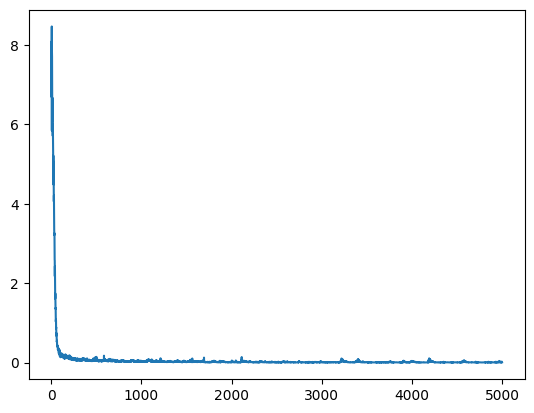

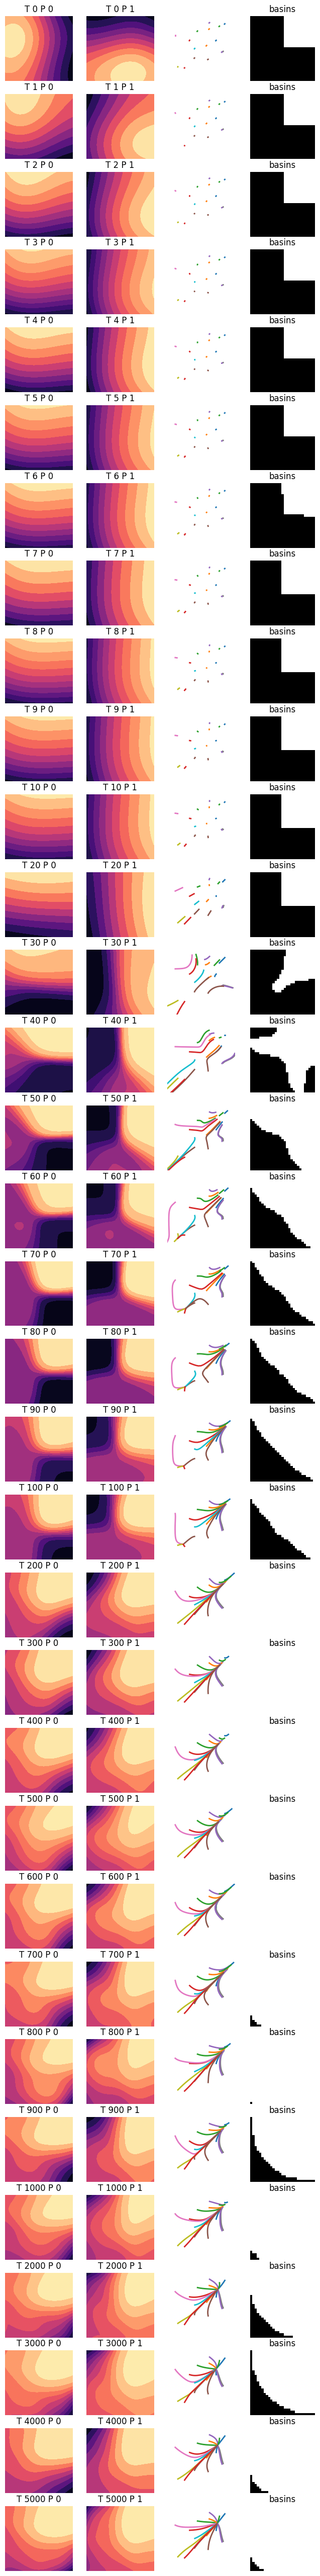

In [10]:
def plot_training_process(vhat_trace, gamma=0.99):
  def plot_vhat_contour(ot, ax, time, player):
    vhat = ot["trace"][time].bind_gamma(gamma)
    vs = jax.vmap(jax.vmap(vhat))(zs)
    ax.contourf(zs[..., 0], zs[..., 1], vs[..., player], cmap="magma", levels=10)
    ax.set_title(f"T {time} P {player}")
    ax.set_axis_off()
  def plot_trajectories(ot, ax, time):
    vhat = ot["trace"][time].bind_gamma(gamma)
    trace = train_simple(vhat)
    simple_plot_trajectory(trace["trace"], ax)

  plt.figure()
  plt.plot(vhat_trace["losses"])
  subplots([[partial(plot_vhat_contour, vhat_trace, time=time, player=0), partial(plot_vhat_contour, vhat_trace, time=time, player=1),
             partial(plot_trajectories, vhat_trace, time=time), partial(plot_basins, vhat_trace["trace"][time].bind_gamma(gamma))]
            for time in logspacedindices(vhat_trace["itraces"])],
          subplot_wh_hint=(4, 4))
plot_training_process(vhat_trace)

pass

# COLA

In [11]:
# COLA is pretty similar structurally; since parameters are scalar, the gradient
# has the same shape as the objective. so we can reuse vhat data structures.
# NOTE gamma is now the extrapolation step size (aka alpha)

In [12]:
def cola_loss_fn(ghat, x, gamma):
  [P] = x.shape
  assert gamma.shape == (P,)
  # loss is ||ghat(x) - grad_x f(x + gamma ghat(x))||
  predictions = ghat(x, gamma)
  def f_cola(x):
    x_extra = x+gamma*ghat(x,gamma)
    assert x.shape == (2,)
    return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
    ])
  targets = partial(diagjac, f_cola)(x)
  losses = huber(targets-predictions)
  return losses.mean()

def do_train_cola(lr=5e-4, seed=1, batch_size=256):
  train_rng,init_rng = rax.split(rax.PRNGKey(seed))
  ghat = VHat.init(VHatModule(quantiles=1), init_rng)
  optimizer = Adam.make_for(ghat, lr=lr)
  otrace = [ghat]; losses = []

  @jax.jit
  def update_ghat(optimizer, ghat, xs, gammas):
    def loss_fn(ghat):
      losses = jax.vmap(partial(cola_loss_fn, ghat))(xs, gammas)
      return losses.mean()
    loss, dghat = jax.value_and_grad(loss_fn)(ghat)
    optimizer, dghat = optimizer(ghat, dghat)
    ghat = deepmap(lambda x, dx: x-dx, ghat, dghat)
    return optimizer, ghat, loss
  for i in range(5001):
    train_rng,gamma_rng,inner_init_rng = rax.split(train_rng,3)
    xs = (rax.uniform(inner_init_rng, shape=[batch_size,2]) * 2 - 1) * 8
    gammas = 30*rax.uniform(gamma_rng, shape=[batch_size,2])
    optimizer, ghat, loss = update_ghat(optimizer, ghat, xs, gammas)
    otrace.append(ghat); losses.append(loss)
  return dict(trace=otrace, losses=losses)

cola_trace = do_train_cola()
final_cola = cola_trace["trace"][-1]
def g_cola(x, gamma=1.):
  return final_cola.bind_gamma(gamma)(x)

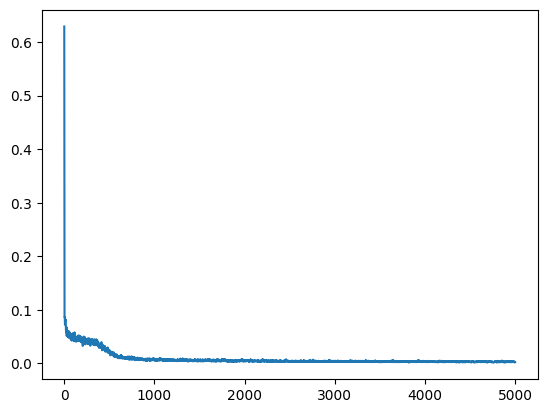

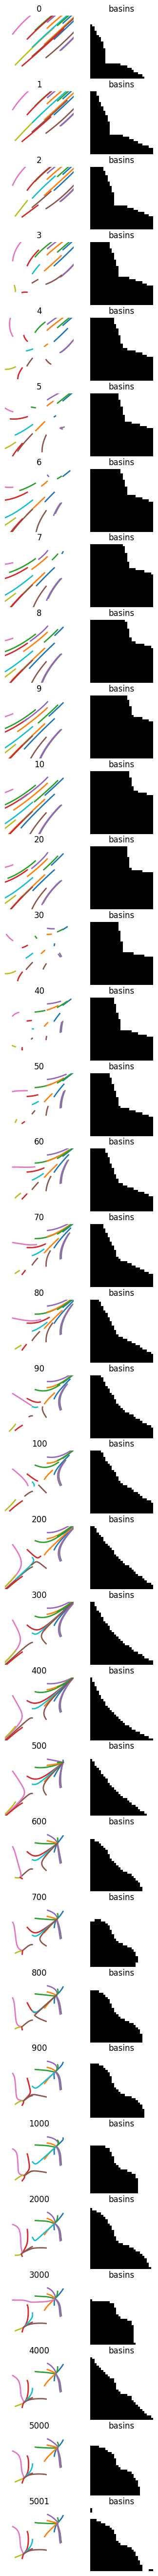

In [13]:
def plot_cola_training_process(cola_trace, gamma=1.0):
  def plot_trajectories(ot, ax, time):
    ghat = ot["trace"][time].bind_gamma(gamma)
    trace = train_simpleg(ghat)
    simple_plot_trajectory(trace["trace"], ax)
    ax.set_title(str(time))

  plt.figure()
  plt.plot(cola_trace["losses"])
  subplots([[partial(plot_trajectories, cola_trace, time=time), partial(plot_basinsg, cola_trace["trace"][time].bind_gamma(gamma))]
            for time in logspacedindices(cola_trace["trace"])],
          subplot_wh_hint=(4, 4))
plot_cola_training_process(cola_trace)

pass

# Naive/LOLA

In [14]:
def f_lola(x, alpha=1.):  # LOLA-DiCE variant
  x_extra = x + alpha*diagjac(f,x)
  assert x.shape == (2,)
  return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
  ])

def f_lola_taylor(x, alpha=1.):  # original LOLA variant
  fprime = jax.jacrev(f)(x)
  g = jp.diag(fprime)
  fprime_offdiag = (1 - jp.eye(fprime.shape[0])) * fprime
  return f(x) + alpha * fprime_offdiag @ g

def f_hola(x, alpha=1., n=1):  # higher-order LOLA (from the orig LOLA paper)
  if n <= 0:
    return f(x)
  x_extra = x + alpha * diagjac(partial(f_hola, alpha=alpha, n=n-1),x)
  return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
  ])

pass

# Evaluation

In [15]:
def compute_endpoints(g, T=200):
  @jax.jit
  def step_fn(optimizer, x):
    dx = g(x)
    optimizer, dx = optimizer(x, dx)
    x = deepmap(lambda x,dx: x+dx, x,dx)
    return optimizer, x
  x = zs
  optimizer = jax.vmap(jax.vmap(partial(Sga.make_for, lr=1)))(x)
  for _ in range(T):
    optimizer, x = jax.vmap(jax.vmap(step_fn))(optimizer, x)
  return x

trails = dict()
endpoints = dict()
def dothings(label, g):
  trails[label] = train_fromg(g, example_init)["trace"]
  endpoints[label] = compute_endpoints(g)
dothings("f", partial(diagjac,f))
for gammastr in "00 50 80 85 90 95 99".split():
  gamma = float(f"0.{gammastr}")
  dothings(f"meva:{gammastr}", partial(diagjac, partial(f_vhat, gamma=gamma)))
for alphastr in "0.0 0.1 1.0 5.0 10.0 20.0 30.0".split():
  alpha = float(alphastr)
  dothings(f"cola:{alphastr}", partial(g_cola, gamma=alpha))
  dothings(f"lola:{alphastr}", partial(diagjac, partial(f_lola, alpha=alpha)))
  dothings(f"hola2:{alphastr}", partial(diagjac, partial(f_hola, alpha=alpha, n=2)))

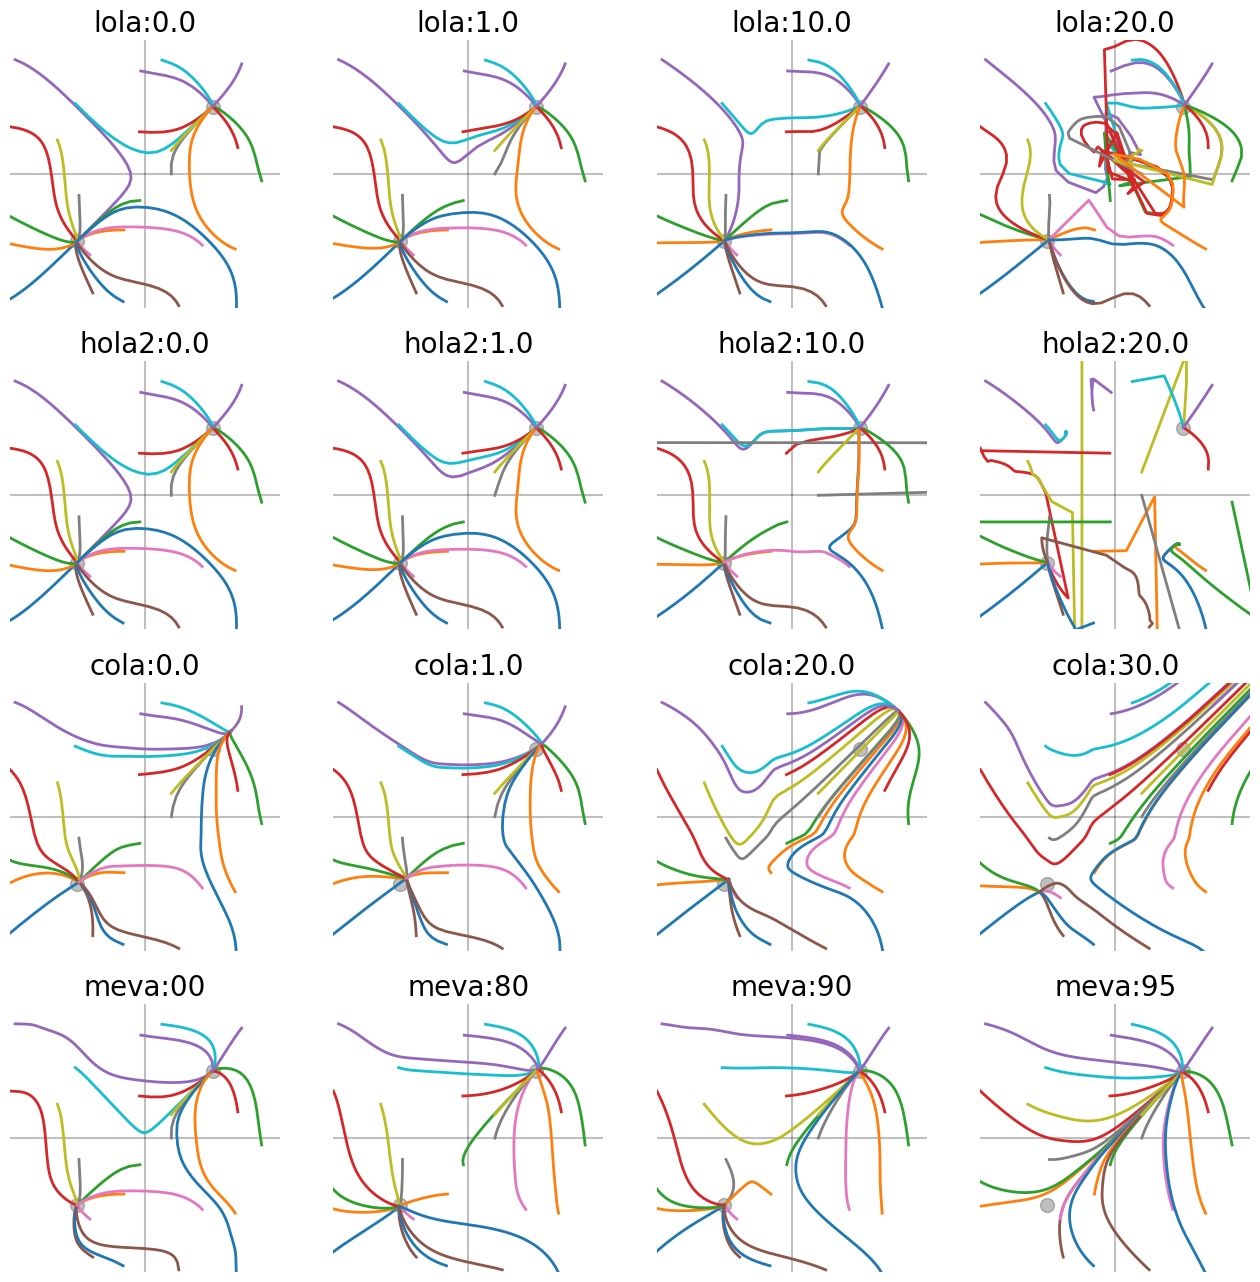

In [16]:
def simple_plot_contour2(f, ax, player):
  fs = jax.vmap(jax.vmap(f))(zs)
  ax.contourf(zs[..., 0], zs[..., 1], fs[..., player], cmap="magma", levels=10)
  ax.set_title(f"P {player}")
  ax.set_axis_off()
def simple_plot_trajectory2(trace, ax, title=None):
  # plot social objective contours for orientation
  #fs = jax.vmap(jax.vmap(f))(zs)
  #ax.contour(zs[..., 0], zs[..., 1], fs.mean(axis=-1), cmap="gray", alpha=0.5)#, levels=10)
  # plot axis lines and a circle at good/bad solutions?
  ax.axhline(0., color="k", alpha=0.25); ax.axvline(0., color="k", alpha=0.25)
  ax.scatter(*goodx[:,None], c="k", alpha=0.25, marker="o", s=100)
  ax.scatter(*badx[:,None], c="k", alpha=0.25, marker="o", s=100)

  # plot trajectories
  ax.plot(trace[..., 0].T, trace[..., 1].T, linewidth=2)
  if title is not None:
    ax.set_title(title, fontsize=20)
  ax.set_xlim((-10, +10))
  ax.set_ylim((-10, +10))
  ax.set_axis_off()

subplots([[partial(simple_plot_trajectory2, trails[key], title=key) for key in "lola:0.0 lola:1.0 lola:10.0 lola:20.0".split()],
          [partial(simple_plot_trajectory2, trails[key], title=key) for key in "hola2:0.0 hola2:1.0 hola2:10.0 hola2:20.0".split()],
          [partial(simple_plot_trajectory2, trails[key], title=key) for key in "cola:0.0 cola:1.0 cola:20.0 cola:30.0".split()],
          [partial(simple_plot_trajectory2, trails[key], title=key) for key in "meva:00 meva:80 meva:90 meva:95".split()],
          ],
         subplot_wh_hint=(4, 4))

pass

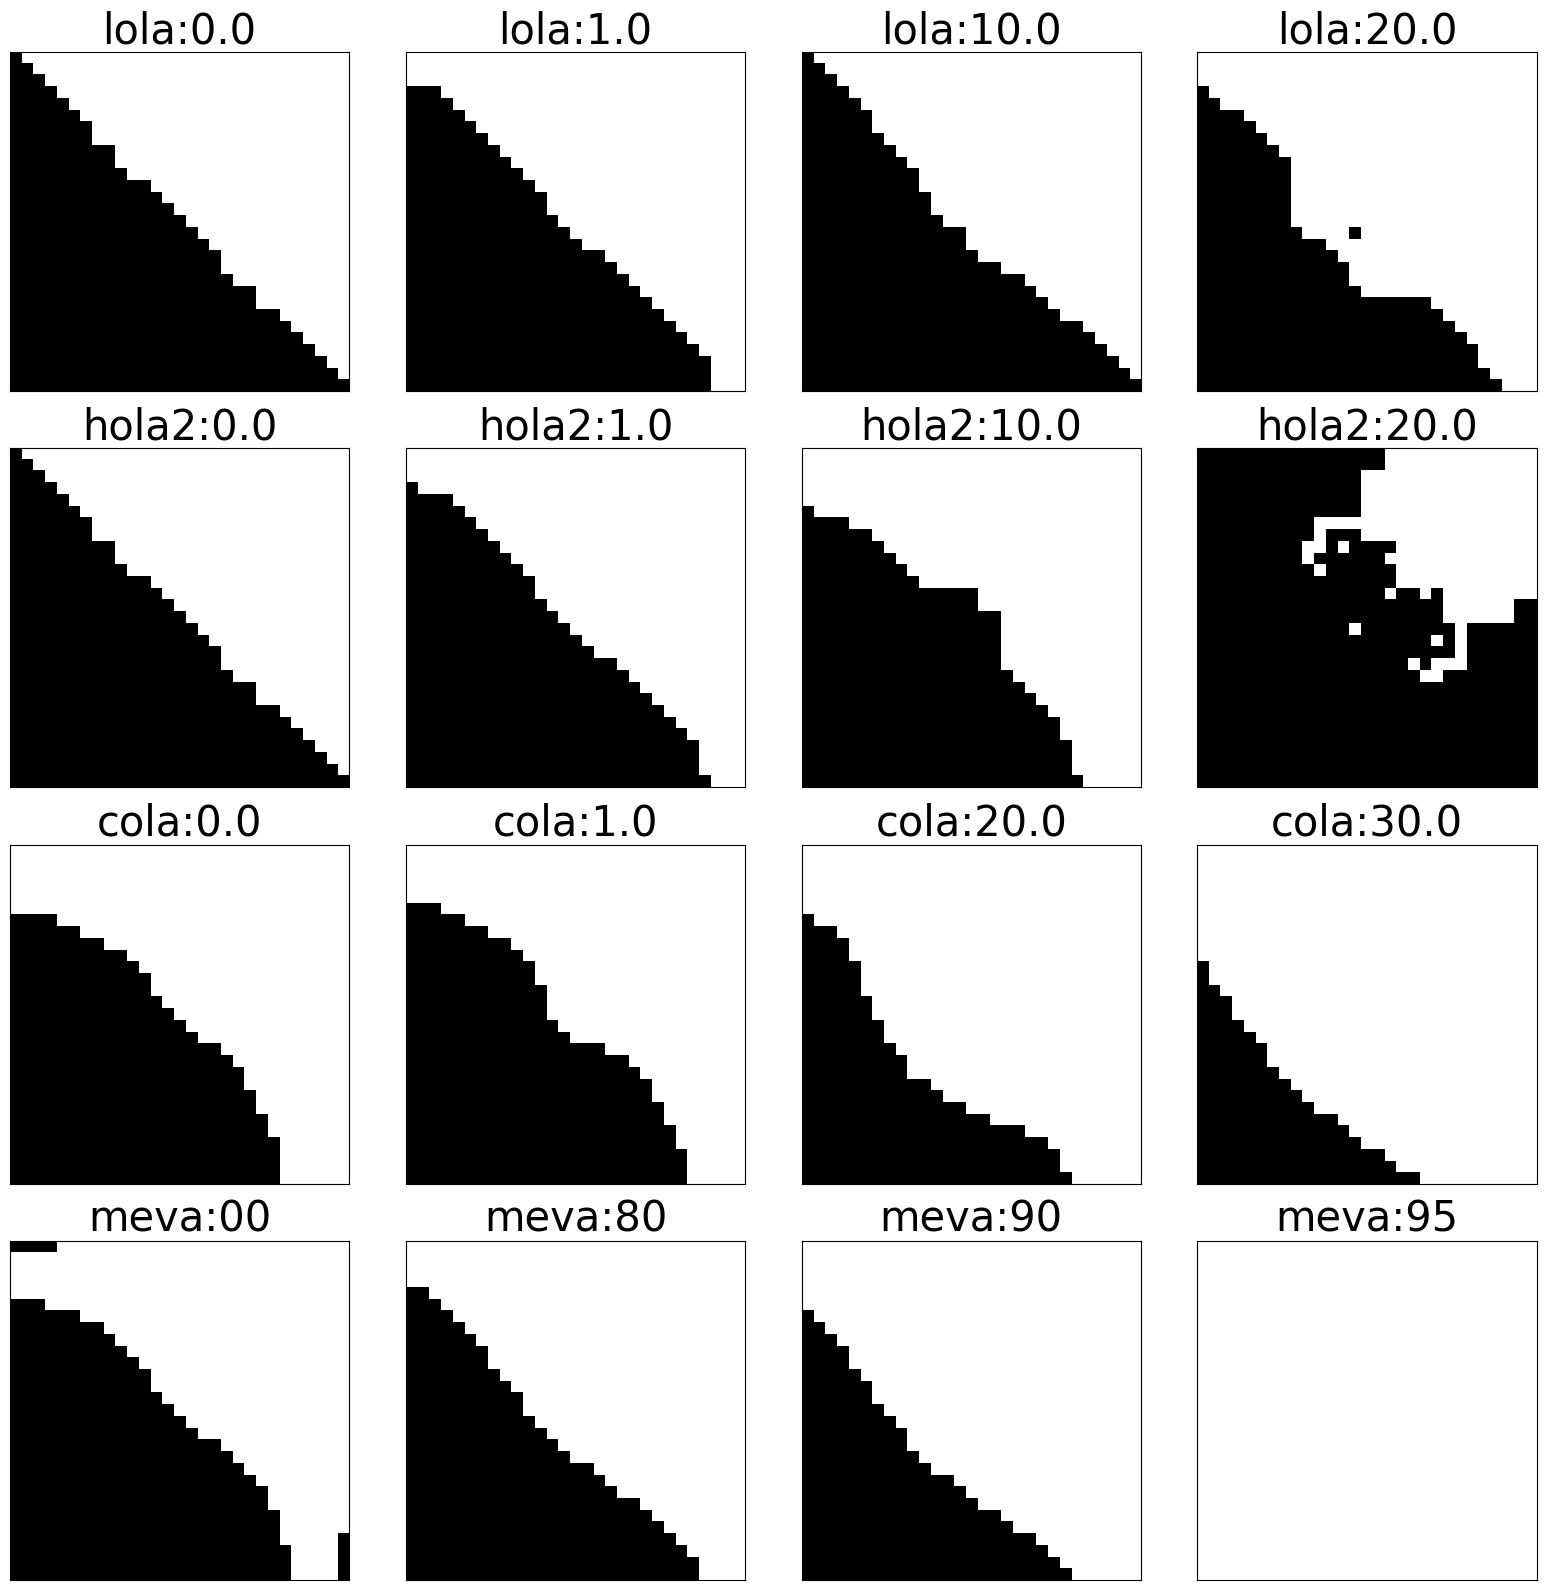

In [17]:
def plot_grid_endpoints(x, ax, title=None, **kwargs):
  if False:
    v = x.max(axis=-1)  # across players; show the worst case
    ax.imshow(v, cmap="RdBu", interpolation="none", origin="lower", vmin=-8, vmax=+8, **kwargs)
  else:
    v = (x>0).all(axis=-1)  # show whether players ended up in upper right quadrant
    ax.imshow(v, cmap="gray", interpolation="none", origin="lower", vmin=0, vmax=1, **kwargs)
  if title is not None:
    ax.set_title(title, fontsize=30)#, labelpad=20)

  #ax.set_axis_off()
  ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False, right=False, labelleft=False,
    labelbottom=False) # labels along the bottom edge are off

subplots([[partial(plot_grid_endpoints, endpoints[key], title=key) for key in "lola:0.0 lola:1.0 lola:10.0 lola:20.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "hola2:0.0 hola2:1.0 hola2:10.0 hola2:20.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "cola:0.0 cola:1.0 cola:20.0 cola:30.0".split()],
          [partial(plot_grid_endpoints, endpoints[key], title=key) for key in "meva:00 meva:80 meva:90 meva:95".split()],
          ],
         subplot_wh_hint=(4, 4))
plt.tight_layout()

pass